# Firefox crash reports missing minidumps

This covers searches for the various scenarios where Firefox crash reports are
missing minidumps for September 2021.

In [1]:
import json
import os

import matplotlib.pyplot as plt
import pandas as pd
import requests

HOST = "https://crash-stats.mozilla.org"

def fetch_supersearch(params):
    headers = {"User-Agent": "jupyter-notebook"}
    resp = requests.get(HOST + "/api/SuperSearch/", params=params, headers=headers)
    return resp.json()

params = {
    "date": [">=2021-09-01", "<2021-09-30"],
    "product": "Firefox",
}

How many crash reports are there in this time range?

In [2]:
total = fetch_supersearch(params)["total"]
print(f"{total:,}")

1,807,269


## malformed minidumps

Crash reports that have a malformed minidump will have a message in `processor_notes` like `MDSW failed with ...`.

In [3]:
malformed_params = dict(params, processor_notes="~MDSW")

malformed = fetch_supersearch(malformed_params)["total"]
print(f"{malformed:,}")

79,494


Crash reports with "malformed" minidumps come in a few different flavors:

* crash reports with a 0-byte minidump
* crash reports with no minidump at all
* crash reports with corrupted headers or other problems

### 0-byte minidumps

Some crash reports have a minidump, but it's a 0-byte minidump. These have a `minidump_sha256_hash` of `e3b0c44298fc1c149afbf4c8996fb92427ae41e4649b934ca495991b7852b855`.

In [4]:
NOBYTES_SHA256 = "e3b0c44298fc1c149afbf4c8996fb92427ae41e4649b934ca495991b7852b855"

nobytes = fetch_supersearch(dict(malformed_params, minidump_sha256_hash=NOBYTES_SHA256))["total"]
print(f"{nobytes:,}")

71,781


### missing minidumps

Now we need to figure out how many crash reports are missing a minidump altogether. If there's no minidump, then `minidump_sha256_hash` is an empty string. That's kind of irritating to search for, but it's doable. We have to search for values that don't match `[0-9a-f]+`.

In [5]:
missing = fetch_supersearch(dict(malformed_params, minidump_sha256_hash="!@[0-9a-f]+"))["total"]
print(f"{missing:,}")

0


So that's curious. There should be more than 0 missing. If we send a test crash report with no minidump, how does it show up?

Here's a minimal crash report (with the crash ingestion collector host omitted):

```
curl -v -H 'Host: host' \
     -F 'ProductName=Firefox' \
     -F 'Version=92.0.1' \
     -F 'BuildID=20210922161155' \
     "$HOST"
```

How does that show up in Crash Stats?

In [6]:
resp = requests.get("https://crash-stats.mozilla.org/api/ProcessedCrash/?crash_id=5031efbf-6e21-4c1c-b18b-5aa7d0210930")
data = resp.json()
data

{'success': True,
 'startedDateTime': '2021-09-30T20:19:28.875896+00:00',
 'signature': 'EMPTY: no crashing thread identified',
 'process_type': 'parent',
 'uuid': '5031efbf-6e21-4c1c-b18b-5aa7d0210930',
 'minidump_sha256_hash': '',
 'additional_minidumps': [],
 'product': 'Firefox',
 'version': '92.0.1',
 'productid': '',
 'release_channel': '',
 'ReleaseChannel': '',
 'build': '20210922161155',
 'application_build_id': '',
 'major_version': 92,
 'app_notes': '',
 'hangid': None,
 'hang_type': 0,
 'addons_checked': None,
 'addons': [],
 'date_processed': '2021-09-30T20:19:26.764570+00:00',
 'crash_time': 1633033166,
 'client_crash_date': '2021-09-30T20:19:26+00:00',
 'install_age': 0,
 'uptime': 0,
 'last_crash': None,
 'crashedThread': None,
 'truncated': False,
 'address': None,
 'reason': None,
 'cpu_info': 'unknown',
 'cpu_arch': 'unknown',
 'os_name': 'Unknown',
 'os_version': '',
 'flash_version': '[blank]',
 'os_pretty_version': 'Unknown',
 'topmost_filenames': None,
 'processo

If we expand the search to include today, do we pick up this crash report?

In [7]:
fetch_supersearch({
    "date": [">=2021-09-01", "<2021-10-01"],
    "product": "Firefox",
    "minidump_sha256_hash": "!@[0-9a-f]+",
})

{'hits': [{'uuid': '5031efbf-6e21-4c1c-b18b-5aa7d0210930',
   'date': '2021-09-30T20:19:26.764570+00:00',
   'signature': 'EMPTY: no crashing thread identified',
   'product': 'Firefox',
   'version': '92.0.1'}],
 'total': 1,
 'facets': {'signature': [{'term': 'EMPTY: no crashing thread identified',
    'count': 1}]},
 'errors': []}

That's the same crash id (uuid--we have different names for it in different places because reasons) as the one I sent earlier. So the search works and there just aren't any crash reports for Firefox that have no minidump.

### corrupted minidumps

The rest of the malformed minidumps are corrupted. So it's everything that has a `MDSW` minus the ones that have no minidump or have a 0-byte minidump.

In [8]:
corrupted = malformed - missing - nobytes
print(f"{corrupted:,}")

7,713


# Summary

That brings us to the following table with percentages.

In [9]:
results = [f"{malformed:,}", f"{total:,}", f"{malformed / total * 1000:.2f}%"]
pd.DataFrame([results], columns=["malformed", "total", "percentage"])



,malformed,total,percentage
0,"79,494","1,807,269",43.99%


Breaking down malformed crash reports into reasons, we get:

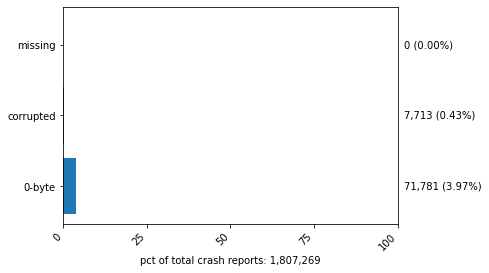

In [10]:
nobytes_pct = nobytes / total * 100
corrupted_pct = corrupted / total * 100
missing_pct = missing / total * 100

data = {
    "0-byte": nobytes_pct,
    "corrupted": corrupted_pct,
    "missing": missing_pct,
}
keys = list(data.keys())
values = list(data.values())

fig, ax = plt.subplots()
ax.barh(keys, values)
labels = ax.get_xticklabels()
plt.setp(labels, rotation=45, horizontalalignment='right')
ax.set(xlim=[0, 100], xlabel=f"pct of total crash reports: {total:,}")
ax.set_xticks([0, 25, 50, 75, 100])

ax.text(102, 0, f"{nobytes:,} ({nobytes_pct:.2f}%)", fontsize=10, verticalalignment="center")
ax.text(102, 1, f"{corrupted:,} ({corrupted_pct:.2f}%)", fontsize=10, verticalalignment="center")
ax.text(102, 2, f"{missing:,} ({missing_pct:.2f}%)", fontsize=10, verticalalignment="center")
plt.show()